In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
from numpy import mean
from numpy import std
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import scale 
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn import linear_model

**1. Produce some numerical and graphical summaries of data (pairplot, correlation matrix, boxplot).**


In [2]:
data = pd.read_csv('Credit.csv')
data.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


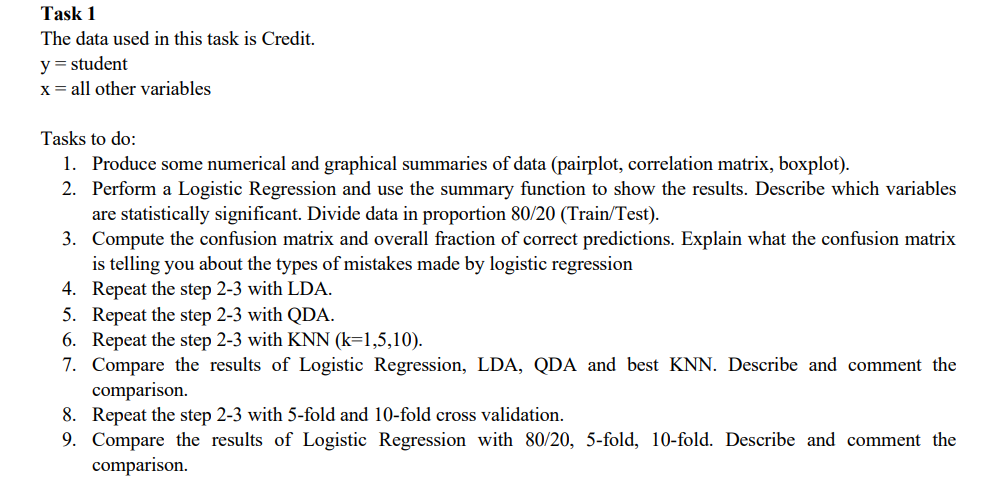

In [4]:
# Check for missing data
assert data.isnull().sum().sum() == 0

In [5]:
# Pre-processing
from sklearn.preprocessing import OrdinalEncoder

data = data.copy()
encoding = OrdinalEncoder()
encoding.fit(data[['Own', 'Student', 'Married', 'Region']])
data[['Own', 'Student', 'Married', 'Region']] = encoding.transform(data[['Own', 'Student', 'Married', 'Region']])
data.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,0.0,0.0,1.0,1.0,333
1,106.025,6645,483,3,82,15,1.0,1.0,1.0,2.0,903
2,104.593,7075,514,4,71,11,0.0,0.0,0.0,2.0,580
3,148.924,9504,681,3,36,11,1.0,0.0,0.0,2.0,964
4,55.882,4897,357,2,68,16,0.0,0.0,1.0,1.0,331


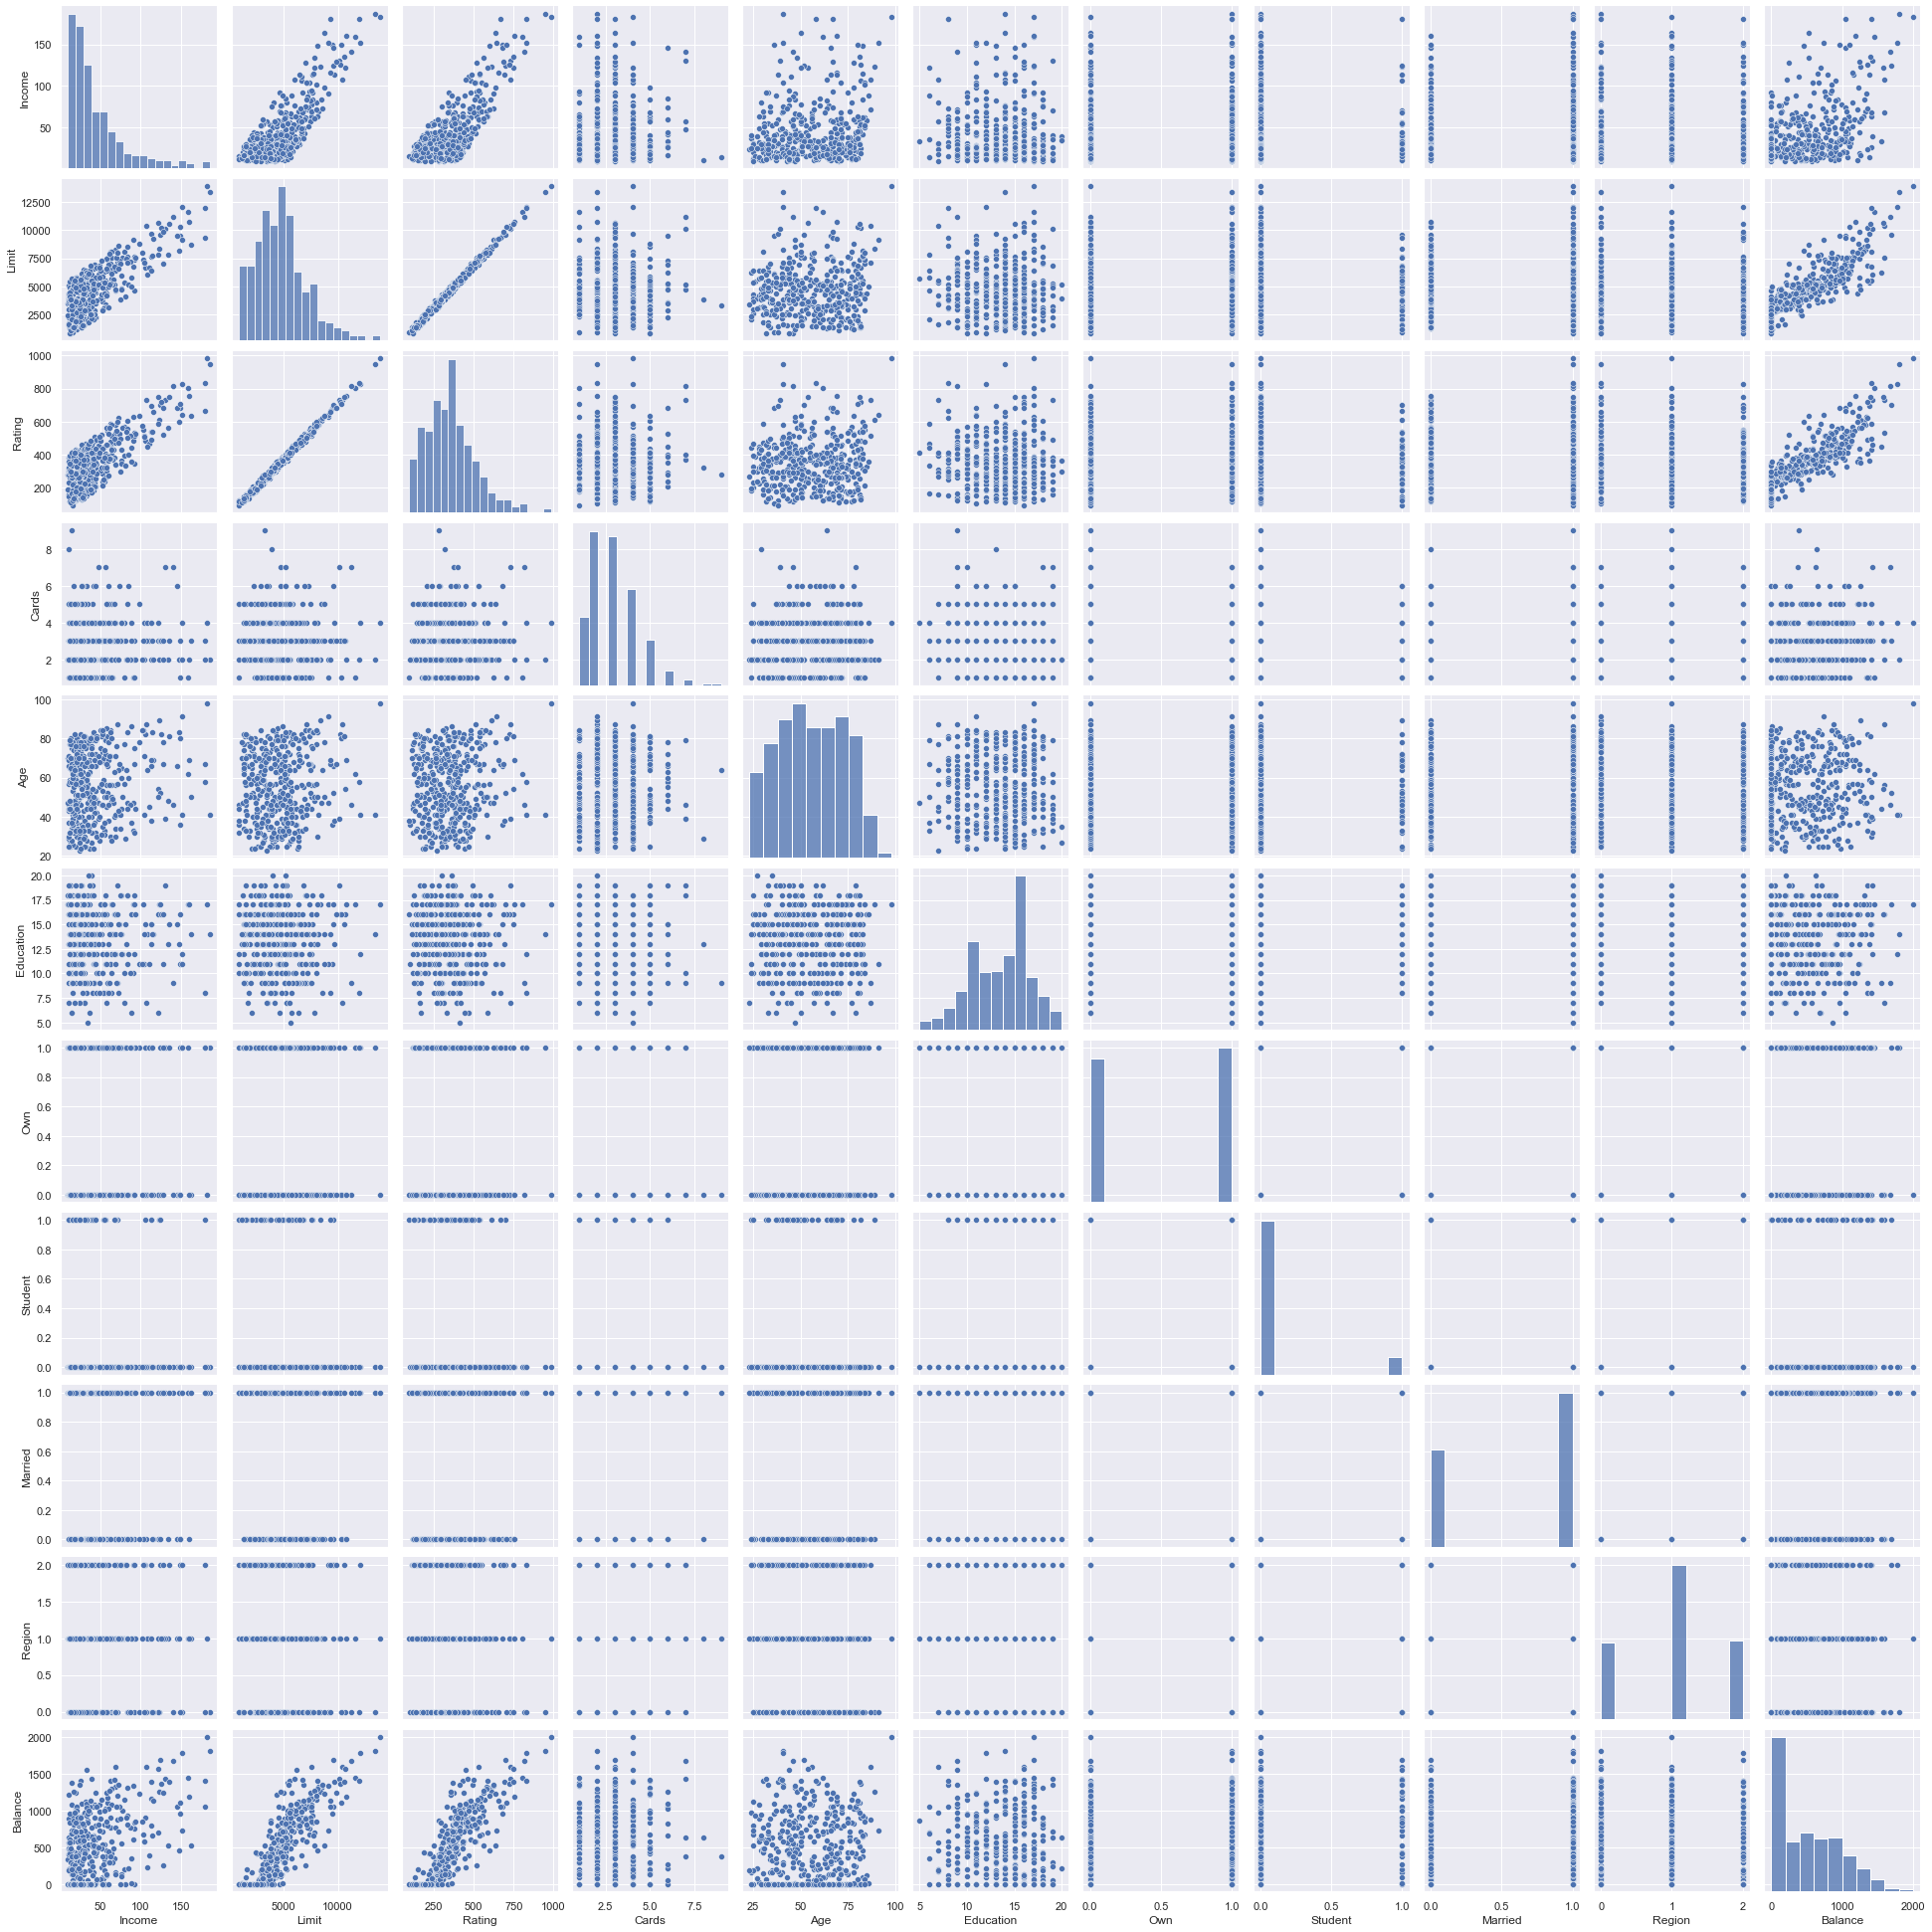

In [6]:
# Pairplot
sns.pairplot(data);

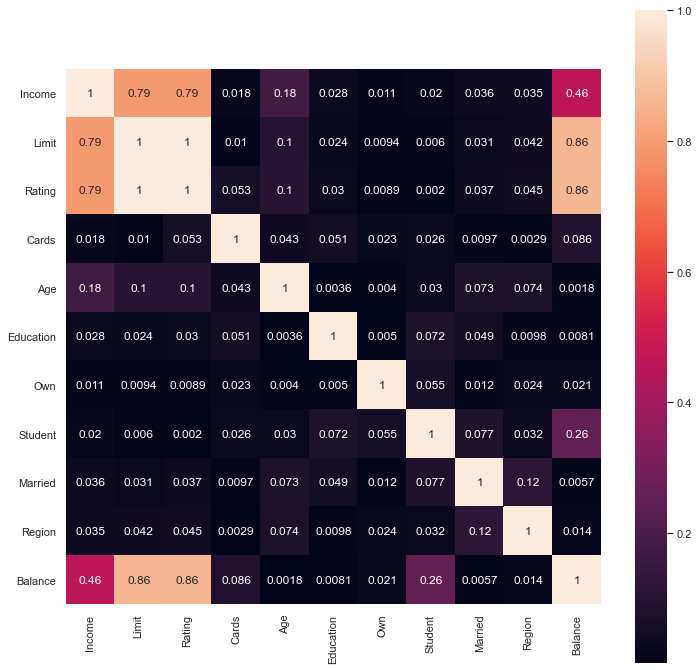

In [33]:
corr_matrix = data.corr().abs()
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

Matrix shows that those variables have strong correlation :
+ Income – Limit
+ Rating – Balance
+ Limit - Balance
+ Income - Rating

Looking at the pairplot above suggests:

+ Limit increases linearly with Income
+ Balance increases linearly with Rating

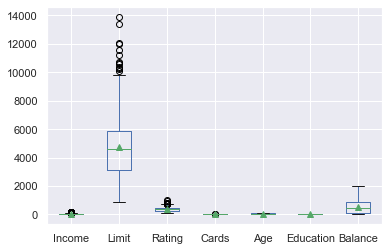

In [8]:
ax = data[['Income','Limit','Rating','Cards', 'Age','Education','Balance']].plot(kind='box', showmeans=True)

plt.show()

In [9]:
# fitting model to complete dataset, keep in mind that we didn't use 'Limit' column because limit and rating are the 
f = 'Student ~ Income + Rating + Cards + Age + Education + Own + Married + Region + Balance'

# logistic regression model 
m = sm.Logit.from_formula(formula=f, data=data).fit()

# Display model summary
display(m.summary())

# Statistically significant predictors
display(HTML('<h3>Statistically significant predictors:</h3>'))
display(pd.DataFrame({'p>|z|': m.pvalues[m.pvalues < 0.05].drop('Intercept')}))

Optimization terminated successfully.
         Current function value: 0.022046
         Iterations 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Student   No. Observations:                  400
Model:                          Logit   Df Residuals:                      390
Method:                           MLE   Df Model:                            9
Date:                Tue, 03 May 2022   Pseudo R-squ.:                  0.9322
Time:                        17:38:04   Log-Likelihood:                -8.8183
converged:                       True   LL-Null:                       -130.03
Covariance Type:            nonrobust   LLR p-value:                 3.949e-47
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.4002      7.543      2.440      0.015       3.617      33.183
Income         0.6046      0.244      2.477      0.013       0.126       1.083
Rating        -0.3431      0.140     -2.459      0.014      -0.617      -0.070
Cards          1.0642      1.084      0.982      0.326      -1.061       3.189
Age            0.0934      0.064      1.464      0.143      -0.032       0.218
Education      0.0954      0.268      0.356      0.721      -0.429       0.620
Own            1.3005      1.616      0.805      0.421      -1.866       4.467
Married        0.7786      1.677      0.464      0.642      -2.508       4.065
Region        -0.9632      1.098     -0.877      0.380      -3.115       1.189
Balance        0.0911      0.038      2.420      0.016       0.017       0.165
==============================================================================

Possibly complete quasi-separation: A fraction 0.87 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

,p>|z|
Income,0.013258
Rating,0.013939
Balance,0.015512


**2. Perform a Logistic Regression and use the summary function to show the results. Describe which variables
are statistically significant. Divide data in proportion 80/20 (Train/Test).**

In [10]:
# choosing only statistically significant predictors and dividing dataset on 80/20 and applying the model
s = 'Student ~ Income + Rating + Balance'

X_train, X_test, y_train, y_test = train_test_split(data[['Income', 'Rating', 'Balance']], data['Student'], test_size=0.2, random_state=3)

ms = sm.Logit.from_formula(formula=s, data=pd.concat([X_train, y_train], axis=1)).fit()

Optimization terminated successfully.
         Current function value: 0.029207
         Iterations 12


**3. Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix
is telling you about the types of mistakes made by logistic regression**

In [11]:
def confusion_table(confusion_mtx):
    """Renders a nice confusion table with labels"""
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df


def positive_observations(y):
    # What percentage of observations are positive?
    proportion_1 = ((y == 1).sum() / len(y))
    pct_1        = np.around(proportion_1*100, decimals=3)
    display(HTML('<p><h4>{}%</h4>of observations are positive</p>'.format(pct_1)))


# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_matrix):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def total_error_rate(confusion_matrix):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def false_negative_rate(confusion_mtx):
    """the proportion of actual POSITIVES that are incorrectly identified as negative"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def false_positive_rate(confusion_mtx):
    """the proportion of actual NEGATIVES that are incorrectly identified as positives"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def negative_predictive_value(confusion_mtx):
    """the proportion of predicted negatives that are correctly predicted"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'false_negative_rate': false_negative_rate(confusion_mtx),
                      'false_positive_rate': false_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx),
                      'negative_predictive_value': negative_predictive_value(confusion_mtx)})

**4. Repeat the step 2-3 with LDA.**


A confusion matrix is used to define the performance of a classification algorithm, it visualizes and summarizes the performance of a classification algorithm.

In [12]:
# Get confusion matrix using test data
threshold = 0.5
y_pred_logit = (ms.predict(X_test) > threshold).astype(int)
confusion_mtx = confusion_matrix(y_test, y_pred_logit)

# Render as nice table
display(confusion_table(confusion_mtx))

# Classifier stats
logit_stats = classifier_stats(confusion_mtx)
logit_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,67,0,67
y=1,1,12,13
Total,68,12,


prior_error_rate                         0.837500
total_error_rate                         0.012500
true_positive_rate (sensitivity)         0.923077
false_negative_rate                      0.076923
false_positive_rate                      0.000000
true_negative_rate (specificity)         1.000000
positive_predictive_value (precision)    1.000000
negative_predictive_value                0.985294
dtype: float64

In [13]:
# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

In [14]:
# % of positive observations
positive_observations(y_test)

### LDA

In [16]:
# % of positive observations
positive_observations(y_test)

# Fit model
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)

# Predict
y_pred_lda = lda_model.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_lda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
lda_stats = classifier_stats(confusion_mtx)
lda_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,67,0,67
y=1,1,12,13
Total,68,12,


prior_error_rate                         0.837500
total_error_rate                         0.012500
true_positive_rate (sensitivity)         0.923077
false_negative_rate                      0.076923
false_positive_rate                      0.000000
true_negative_rate (specificity)         1.000000
positive_predictive_value (precision)    1.000000
negative_predictive_value                0.985294
dtype: float64

**5. Repeat the step 2-3 with QDA.**


In [18]:
# Fit model
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train, y_train)
y_pred_qda = qda_model.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_qda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
qda_stats = classifier_stats(confusion_mtx)
qda_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,65,2,67
y=1,0,13,13
Total,65,15,


prior_error_rate                         0.837500
total_error_rate                         0.025000
true_positive_rate (sensitivity)         1.000000
false_negative_rate                      0.000000
false_positive_rate                      0.029851
true_negative_rate (specificity)         0.970149
positive_predictive_value (precision)    0.866667
negative_predictive_value                1.000000
dtype: float64

In [19]:
# % of positive observations
positive_observations(y_test)


**6. Repeat the step 2-3 with KNN (k=1,5,10).**


In [21]:
# % of positive observations
positive_observations(y_train)

# Model with k=1
K = 1
k_1_model = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
y_pred_knn = k_1_model.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_knn)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
knn_stats_1 = classifier_stats(confusion_mtx)
knn_stats_1

,y_pred=0,y_pred=1,Total
,,,
y=0,67,0,67
y=1,5,8,13
Total,72,8,


prior_error_rate                         0.837500
total_error_rate                         0.062500
true_positive_rate (sensitivity)         0.615385
false_negative_rate                      0.384615
false_positive_rate                      0.000000
true_negative_rate (specificity)         1.000000
positive_predictive_value (precision)    1.000000
negative_predictive_value                0.930556
dtype: float64

### KNN where k =5

In [23]:
positive_observations(y_train)

# Model with k=5
K = 5
k_5_model = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
y_pred_knn = k_5_model.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_knn)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
knn_stats_5 = classifier_stats(confusion_mtx)
knn_stats_5

,y_pred=0,y_pred=1,Total
,,,
y=0,67,0,67
y=1,9,4,13
Total,76,4,


prior_error_rate                         0.837500
total_error_rate                         0.112500
true_positive_rate (sensitivity)         0.307692
false_negative_rate                      0.692308
false_positive_rate                      0.000000
true_negative_rate (specificity)         1.000000
positive_predictive_value (precision)    1.000000
negative_predictive_value                0.881579
dtype: float64

### KNN where k= 10

In [25]:
positive_observations(y_train)

# Model with k=10
K = 10
k_10_model = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
y_pred_knn = k_10_model.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_knn)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
knn_stats_10 = classifier_stats(confusion_mtx)
knn_stats_10

,y_pred=0,y_pred=1,Total
,,,
y=0,67,0,67
y=1,11,2,13
Total,78,2,


prior_error_rate                         0.837500
total_error_rate                         0.137500
true_positive_rate (sensitivity)         0.153846
false_negative_rate                      0.846154
false_positive_rate                      0.000000
true_negative_rate (specificity)         1.000000
positive_predictive_value (precision)    1.000000
negative_predictive_value                0.858974
dtype: float64


**7. Compare the results of Logistic Regression, LDA, QDA and best KNN. Describe and comment the
comparison.**


In [27]:
compare = pd.DataFrame({'logit': logit_stats,
                        'lda'  : lda_stats,
                        'qda'  : qda_stats,
                        'knn_1'  : knn_stats_1,
                        'knn_5' : knn_stats_5,
                        'knn_10': knn_stats_10}).T
display(compare.T)

,logit,lda,qda,knn_1,knn_5,knn_10
prior_error_rate,0.837500,0.837500,0.837500,0.837500,0.837500,0.837500
total_error_rate,0.012500,0.012500,0.025000,0.062500,0.112500,0.137500
true_positive_rate (sensitivity),0.923077,0.923077,1.000000,0.615385,0.307692,0.153846
false_negative_rate,0.076923,0.076923,0.000000,0.384615,0.692308,0.846154
false_positive_rate,0.000000,0.000000,0.029851,0.000000,0.000000,0.000000
true_negative_rate (specificity),1.000000,1.000000,0.970149,1.000000,1.000000,1.000000
positive_predictive_value (precision),1.000000,1.000000,0.866667,1.000000,1.000000,1.000000
negative_predictive_value,0.985294,0.985294,1.000000,0.930556,0.881579,0.858974


**we can see that the smallest amounts of total error rate are logit and lda.**


**8. Repeat the step 2-3 with 5-fold and 10-fold cross validation.**


In [29]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

lm = LogisticRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.981 (0.012)


In [30]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

lm = LogisticRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.981 (0.021)



**9. Compare the results of Logistic Regression with 80/20, 5-fold, 10-fold. Describe and comment the
comparison.**

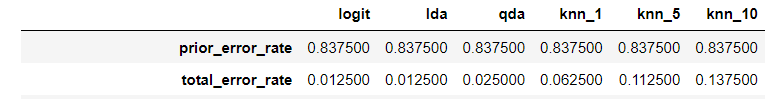

1)As you could observe from results , knn_1 had the greatest total error rate , while on the other hand knn at 5 and 10 folds have only 11% and 13,75% respectively

2)Logit , Lda and knn at 5 folds seem to be optimal in same data

3)While QDA had twice error rate as previously described results

### Task2

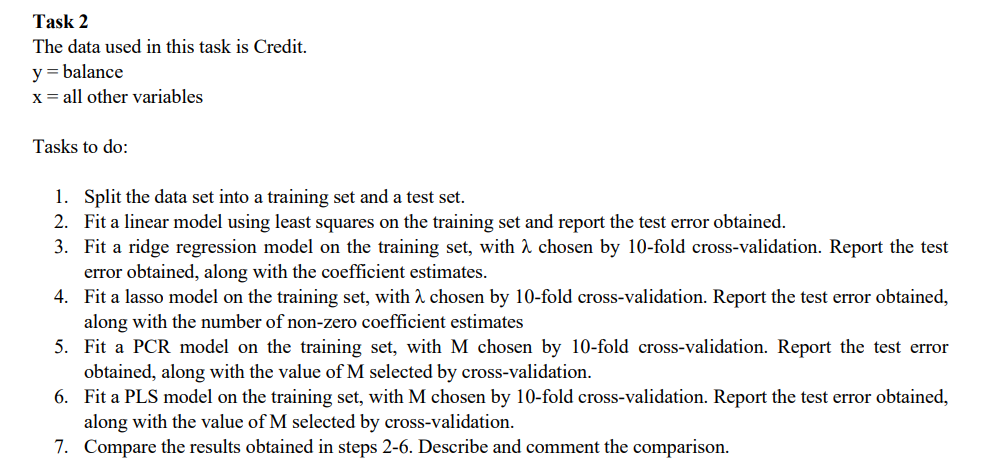

In [37]:
data2 = data.copy()
data2

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,0.0,0.0,1.0,1.0,333
1,106.025,6645,483,3,82,15,1.0,1.0,1.0,2.0,903
2,104.593,7075,514,4,71,11,0.0,0.0,0.0,2.0,580
3,148.924,9504,681,3,36,11,1.0,0.0,0.0,2.0,964
4,55.882,4897,357,2,68,16,0.0,0.0,1.0,1.0,331
...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,0.0,0.0,1.0,1.0,560
396,13.364,3838,296,5,65,17,0.0,0.0,0.0,0.0,480
397,57.872,4171,321,5,67,12,1.0,0.0,1.0,1.0,138
398,37.728,2525,192,1,44,13,0.0,0.0,1.0,1.0,0


In [39]:
f = 'Balance ~ Income + Rating + Cards + Age + Education + Own + Student + Married + Region'
m = smf.ols(formula = f, data = data2).fit()

# Display summary 
display(m.summary())

# Statistically significant predictors
display(HTML('<h3>Statistically significant predictors:</h3>'))
display(pd.DataFrame({'p>|z|': m.pvalues[m.pvalues < 0.05].drop('Intercept')}))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     844.2
Date:                Thu, 14 Apr 2022   Prob (F-statistic):          1.49e-249
Time:                        08:45:49   Log-Likelihood:                -2415.4
No. Observations:                 400   AIC:                             4851.
Df Residuals:                     390   BIC:                             4891.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -549.4489     34.522    -15.916      0.000    -617.322    -481.576
Income        -7.7744      0.243    -31.933      0.000      -8.253      -7.296
Rating         3.9789      0.055     72.444      0.000       3.871       4.087
Cards          3.9664      3.788      1.047      0.296      -3.481      11.413
Age           -0.6416      0.306     -2.099      0.036      -1.243      -0.041
Education     -0.3785      1.656     -0.229      0.819      -3.634       2.877
Own          -10.7085     10.311     -1.039      0.300     -30.981       9.564
Student      416.4542     17.298     24.075      0.000     382.445     450.463
Married      -15.1124     10.714     -1.411      0.159     -36.176       5.952
Region        10.8824      7.329      1.485      0.138      -3.527      25.292
==============================================================================
Omnibus:                       15.644   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.762
Skew:                           0.490   Prob(JB):                     0.000229
Kurtosis:                       2.789   Cond. No.                     2.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,p>|z|
Income,7.105466e-111
Rating,2.558288e-228
Age,3.649767e-02
Student,3.867296e-79


In [40]:
s = 'Balance ~ Income + Rating + Age + Student'

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data[['Income', 'Rating', 'Age', 'Student']], data2['Balance'], test_size=0.2, random_state=3)

sm = smf.ols(formula=s, data=pd.concat([X_train_2, y_train_2], axis=1)).fit()

In [42]:
display(sm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1503.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):          9.06e-204
Time:                        08:47:10   Log-Likelihood:                -1935.0
No. Observations:                 320   AIC:                             3880.
Df Residuals:                     315   BIC:                             3899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -552.1195     23.355    -23.641      0.000    -598.071    -506.168
Income        -7.7268      0.267    -28.932      0.000      -8.252      -7.201
Rating         3.9599      0.061     65.325      0.000       3.841       4.079
Age           -0.4047      0.337     -1.202      0.230      -1.067       0.258
Student      419.6340     20.766     20.208      0.000     378.776     460.492
==============================================================================
Omnibus:                       10.462   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.667
Skew:                           0.420   Prob(JB):                      0.00483
Kurtosis:                       2.692   Cond. No.                     1.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
stand_scaler = StandardScaler()
Z_train = stand_scaler.fit_transform(X_train_2)
Z_train = pd.DataFrame(stand_scaler.transform(X_train_2), columns=X_train_2.columns)
Z_train.head()

,Income,Rating,Age,Student
0,-0.505098,-0.594210,-1.154367,-0.303562
1,1.044520,1.248191,1.607483,-0.303562
2,-0.456518,-0.600541,0.917021,-0.303562
3,0.494642,0.260512,-0.406366,-0.303562
4,-0.982230,-0.486578,-0.636520,-0.303562


In [52]:
scaled_features = StandardScaler().fit_transform(data2.values)
data2 = pd.DataFrame(scaled_features, index=data2.index, columns=data2.columns)

In [55]:
X, y = (data2.drop('Balance', axis=1), data2['Balance'])

In [58]:
m = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
display(m.summary())

display(HTML('<h3>Statistically significant predictors:</h3>'))
display(pd.DataFrame({'p>|z|': m.pvalues[m.pvalues < 0.05]}))
print(f'RMSE: {mean_squared_error(squared=False, y_pred=m.predict(X), y_true=y)}')
print(f'R2_score: {r2_score(y_true=y, y_pred=m.predict(X))}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     844.2
Date:                Thu, 14 Apr 2022   Prob (F-statistic):          1.49e-249
Time:                        08:52:08   Log-Likelihood:                 36.333
No. Observations:                 400   AIC:                            -52.67
Df Residuals:                     390   BIC:                            -12.75
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.388e-17      0.011   1.24e-15      1.000      -0.022       0.022
Income        -0.5960      0.019    -31.933      0.000      -0.633      -0.559
Rating         1.3390      0.018     72.444      0.000       1.303       1.375
Cards          0.0118      0.011      1.047      0.296      -0.010       0.034
Age           -0.0241      0.011     -2.099      0.036      -0.047      -0.002
Education     -0.0026      0.011     -0.229      0.819      -0.025       0.020
Own           -0.0117      0.011     -1.039      0.300      -0.034       0.010
Student        0.2721      0.011     24.075      0.000       0.250       0.294
Married       -0.0160      0.011     -1.411      0.159      -0.038       0.006
Region         0.0168      0.011      1.485      0.138      -0.005       0.039
==============================================================================
Omnibus:                       15.644   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.762
Skew:                           0.490   Prob(JB):                     0.000229
Kurtosis:                       2.789   Cond. No.                         3.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,p>|z|
Income,7.105466e-111
Rating,2.558288e-228
Age,3.649767e-02
Student,3.867296e-79


RMSE: 0.22096083372797062
R2_score: 0.9511763099582401


In [59]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
sm = smf.ols(formula=s, data=pd.concat([X_train_3, y_train_3], axis=1)).fit()
predicted_ols = sm.predict(X_test_3)

print(f'RMSE: {mean_squared_error(y_true=y_test_3, y_pred=predicted_ols, squared=False)}')
print(f'R2_score: {r2_score(y_true=y_test_3, y_pred=predicted_ols)}')

RMSE: 0.20059618816184616
R2_score: 0.9492178978348177


**2. Fit a linear model using least squares on the training set and report the test error obtained.**


In [62]:
alphas = 10**np.linspace(6,-2,50)*0.5
alphas

array([5.00000000e+05, 3.43324423e+05, 2.35743318e+05, 1.61872877e+05,
       1.11149824e+05, 7.63208984e+04, 5.24056567e+04, 3.59842837e+04,
       2.47085668e+04, 1.69661089e+04, 1.16497591e+04, 7.99929360e+03,
       5.49270571e+03, 3.77156003e+03, 2.58973734e+03, 1.77824015e+03,
       1.22102655e+03, 8.38416468e+02, 5.75697700e+02, 3.95302161e+02,
       2.71433772e+02, 1.86379686e+02, 1.27977396e+02, 8.78755312e+01,
       6.03396320e+01, 4.14321386e+01, 2.84493301e+01, 1.95346997e+01,
       1.34134790e+01, 9.21034985e+00, 6.32427608e+00, 4.34255687e+00,
       2.98181166e+00, 2.04745753e+00, 1.40588435e+00, 9.65348864e-01,
       6.62855683e-01, 4.55149089e-01, 3.12527596e-01, 2.14596713e-01,
       1.47352585e-01, 1.01179482e-01, 6.94747747e-02, 4.77047738e-02,
       3.27564278e-02, 2.24921633e-02, 1.54442180e-02, 1.06047544e-02,
       7.28174239e-03, 5.00000000e-03])

 **3. Fit a ridge regression model on the training set, with λ chosen by 10-fold cross-validation. Report the test
error obtained, along with the coefficient estimates.**


In [64]:
ridgecv = RidgeCV(alphas=alphas, normalize=True)
ridgecv.fit(X_train_3, y_train_3)
print("Alpha=", ridgecv.alpha_)
ridge6 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge6.fit(X_train_3, y_train_3)
print("mse = ",mean_squared_error(y_test_3, ridge6.predict(X_test_3)))
print("best model predictors:")
pd.Series(ridge6.coef_, index=X.columns)

Alpha= 0.005
mse =  0.0386068659100975
best model predictors:


Income      -0.564705
Limit        0.750920
Rating       0.556491
Cards        0.047222
Age         -0.023274
Education   -0.006200
Own         -0.012870
Student      0.270556
Married     -0.007805
Region       0.011323
dtype: float64

Alpha of ridge model = 0.005 because >0


**4. Fit a lasso model on the training set, with λ chosen by 10-fold cross-validation. Report the test error obtained,
along with the number of non-zero coefficient estimates**

Text(0, 0.5, 'weights')

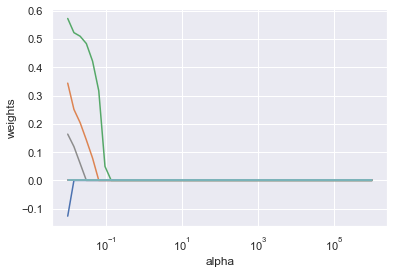

In [68]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train_3), y_train_3)
    coefs.append(lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [69]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train_3, y_train_3)
lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_train_3, y_train_3)
print("mse = ",mean_squared_error(y_test_3, lasso.predict(X_test_3)))
print("best model coefficients:")
pd.Series(lasso.coef_, index=X.columns)

Alpha= 5.047183324799996e-05
mse =  0.03811831282731271
best model coefficients:


Income      -0.574942
Limit        1.009027
Rating       0.308017
Cards        0.057310
Age         -0.021876
Education   -0.006645
Own         -0.012396
Student      0.272284
Married     -0.005159
Region       0.009197
dtype: float64

Here Alpha= 5.047183324799996e-05

**5. Fit a PCR model on the training set, with M chosen by 10-fold cross-validation. Report the test error
obtained, along with the value of M selected by cross-validation.**

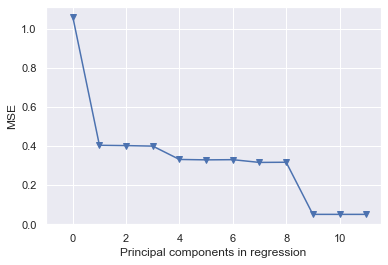

In [76]:
pca = PCA()
X_reduced_train = pca.fit_transform(scale(X_train_3))
n = len(X_reduced_train)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []

score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train_3.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)
for i in np.arange(1, 12):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train_3.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1);

The smallest cv is at M = 9

**6. Fit a PLS model on the training set, with M chosen by 10-fold cross-validation. Report the test error obtained,
along with the value of M selected by cross-validation.**

(-1.0, 10.45)

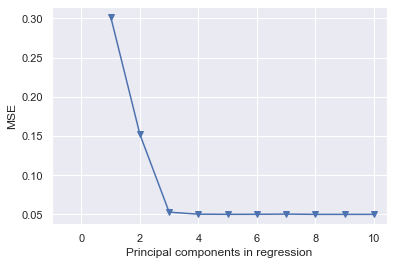

In [81]:
n = len(X_train_3)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse = []
for i in np.arange(1, 12):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train_3), y_train_3, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
    
plt.plot(np.arange(1, 12), np.array(mse), '-v')
plt.xlabel('Principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1)

**7. Compare the results obtained in steps 2-6. Describe and comment the comparison.**


Linear regression (in scikit-learn) is the most basic form, where the model is not penalized for its choice of weights, at all. That means, during the training stage, if the model feels like one particular feature is particularly important, the model may place a large weight to the feature. This sometimes leads to overfitting in small datasets. Hence, following methods are invented.



Lasso is a modification of linear regression, where the model is penalized for the sum of absolute values of the weights. Thus, the absolute values of weight will be (in general) reduced, and many will tend to be zeros. During training, the objective function become:


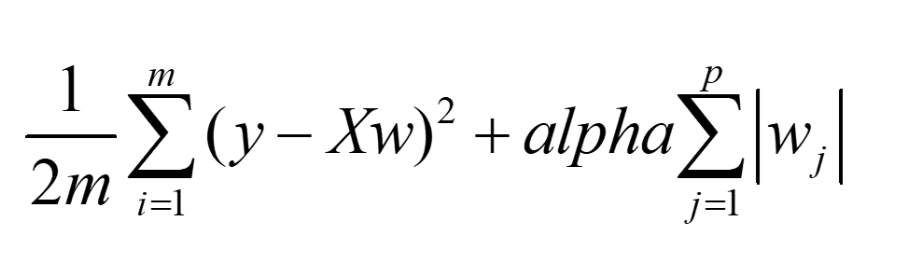



Ridge takes a step further and penalizes the model for the sum of squared value of the weights. Thus, the weights not only tend to have smaller absolute values, but also really tend to penalize the extremes of the weights, resulting in a group of weights that are more evenly distributed. The objective function becomes:

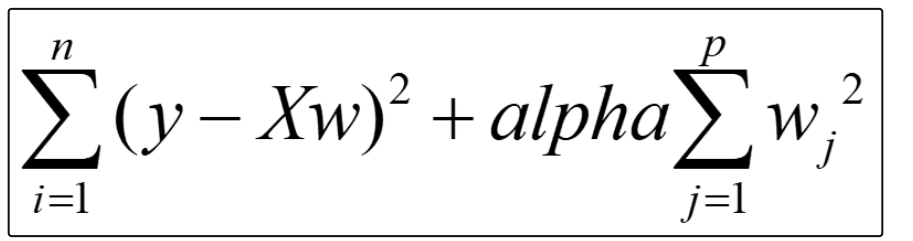